In [1]:
%load_ext autoreload
%autoreload 2

mini_drawings.shape=torch.Size([4, 3, 16, 16])
images.shape=torch.Size([4, 3, 256, 256])


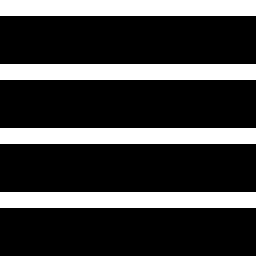

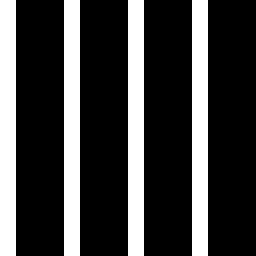

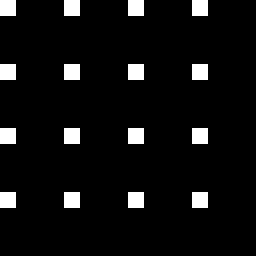

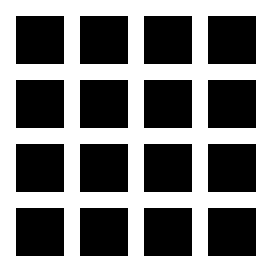

model_inputs.shape=torch.Size([4, 100, 771])
full_features.shape=torch.Size([4, 768, 16, 16])


In [2]:
import torch
from torch import Tensor
from torchvision.transforms.functional import resize, InterpolationMode

from mixed_res.patch_scorers.random_patch_scorer import RandomPatchScorer
from mixed_res.quadtree_impl.quadtree_z_curve import ZCurveQuadtreeRunner
from mixed_res.quadtree_impl.reverse_quadtree import reverse_quadtree
from mixed_res.render import _extract_boxes_from_model_inputs
from mixed_res.render import render_quadtree
from mixed_res.render import tensor_to_pil_image

min_patch_size = 16
max_patch_size = 64
num_patches = 100
num_scales = 3

### Create a batch of cute geometric images
black = torch.zeros((3, 16, 16))
rows, columns, dots, grid = black.clone(), black.clone(), black.clone(), black.clone()
rows[:, ::4, :] = 1
columns[:, :, ::4] = 1
dots[:, ::4, ::4] = 1
grid = torch.clip(rows + columns, 0, 1)
mini_drawings = torch.stack([rows, columns, dots, grid])
print(f"{mini_drawings.shape=}")
bsz, dim, features_width, _ = mini_drawings.shape
images = resize(mini_drawings, [features_width * min_patch_size], InterpolationMode.NEAREST_EXACT)
print(f"{images.shape=}")
for im in images:
    display(tensor_to_pil_image(im))

### Run Quadtree and Reverse-Quadtree
patch_scorer = RandomPatchScorer()
quadtree_runner = ZCurveQuadtreeRunner(num_patches, min_patch_size, max_patch_size)
model_inputs = quadtree_runner.run_batch_quadtree(images, patch_scorer)
print(f"{model_inputs.shape=}")
full_features = reverse_quadtree(model_inputs)
print(f"{full_features.shape=}")


In [3]:
def full_features_to_image(full_features: Tensor):
    assert full_features.ndim == 3
    assert full_features.shape[1] == full_features.shape[2]
    patch_size = int((full_features.shape[0] / 3) ** 0.5)
    image_size = full_features.shape[1] * patch_size
    image = torch.empty((3, image_size, image_size))
    for i in range(full_features.shape[1]):
        for j in range(full_features.shape[2]):
            patch = full_features[:, i, j]
            patch = patch.view(3, patch_size, patch_size)
            image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size] = patch
    image = tensor_to_pil_image(image)
    return image


In [4]:
def assert_conversion_was_successful(model_inputs: Tensor, full_features: Tensor):
    for model_inp, full_feat in zip(model_inputs, full_features):
        boxes, min_patch_size = _extract_boxes_from_model_inputs(model_inp)
        boxes = boxes // min_patch_size
        quadtree_patches = model_inp[..., :-3]
        dim = quadtree_patches.shape[1]
        for quadtree_patch, box in zip(quadtree_patches, boxes):
            l, t, r, b = box
            cropped_patches = full_feat[:, t:b, l:r]
            cropped_patches = cropped_patches.permute(1, 2, 0).reshape(-1, dim)
            quadtree_patch = quadtree_patch[None, :].expand((cropped_patches.shape[0], -1))
            all_replicated_patches_are_equal_to_quadtree_patch = (cropped_patches == quadtree_patch).all()
            assert all_replicated_patches_are_equal_to_quadtree_patch
    print("All Quadtree patches were successfully replicated to the correct places by reverse_quadtree.")


All Quadtree patches were successfully replicated to the correct places by reverse_quadtree.
Image after Quadtree:


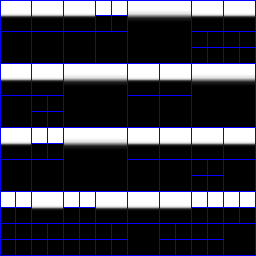

After Reverse-Quadtree, the features of each Quadtree patch (here they are the patch itself) are replicated to fill the entire patch area. Patches of scale 0 stay the same, patches of scale 1 are replicated 2x2 times, patches of scale 2 are replicated 4x4 times.


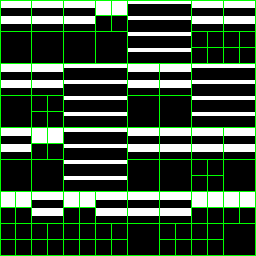

Image after Quadtree:


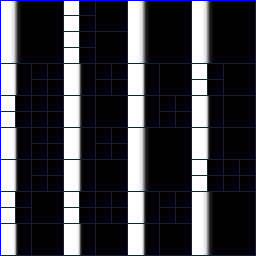

After Reverse-Quadtree, the features of each Quadtree patch (here they are the patch itself) are replicated to fill the entire patch area. Patches of scale 0 stay the same, patches of scale 1 are replicated 2x2 times, patches of scale 2 are replicated 4x4 times.


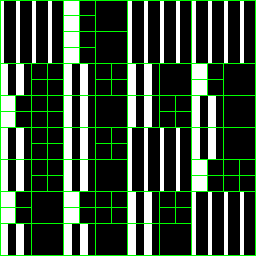

Image after Quadtree:


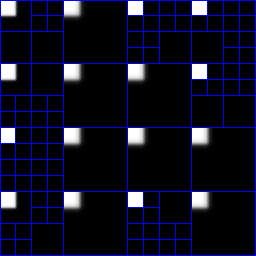

After Reverse-Quadtree, the features of each Quadtree patch (here they are the patch itself) are replicated to fill the entire patch area. Patches of scale 0 stay the same, patches of scale 1 are replicated 2x2 times, patches of scale 2 are replicated 4x4 times.


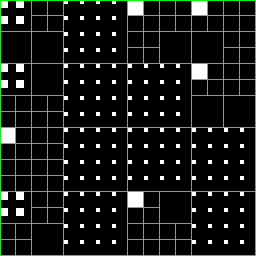

Image after Quadtree:


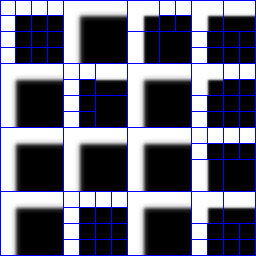

After Reverse-Quadtree, the features of each Quadtree patch (here they are the patch itself) are replicated to fill the entire patch area. Patches of scale 0 stay the same, patches of scale 1 are replicated 2x2 times, patches of scale 2 are replicated 4x4 times.


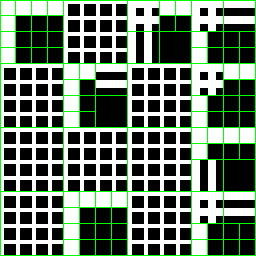

In [5]:
assert_conversion_was_successful(model_inputs, full_features)

for full_feat, model_inp, im in zip(full_features, model_inputs, images):
    feat_image = full_features_to_image(full_feat)
    rendering = render_quadtree(im, model_inp, line_color_rgba=(0, 0, 255, 255))
    rendering_on_feat_image = render_quadtree(feat_image, model_inp, line_color_rgba=(0, 255, 0, 255), blur=False)
    print("Image after Quadtree:")
    display(rendering)
    print("After Reverse-Quadtree, the features of each Quadtree patch (here they are the patch itself) "
          "are replicated to fill the entire patch area. Patches of scale 0 stay the same, patches of scale 1 "
          "are replicated 2x2 times, patches of scale 2 are replicated 4x4 times.")
    display(rendering_on_feat_image)
